# GALSEDATLAS AGN Composites and Applications to the Lyman Break Technique 
This code is intended to test the composite models against against the GALSEDATLAS AGN composites. The code is also intended to test the Lyman Break technique on the GALSEDATLAS AGN composites.


In [12]:
# Read in all required libraries
# Import in all of the required libraries
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# setup all the directories we are getting our data from 

# Skirtor models
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

# Swire templates
swire_folderpath = os.path.join('datasets', 'Templates', 'SWIRE')

# Brown templates
brown_folderpath = os.path.join('datasets', 'Templates', 'Brown', '2014','Rest')

# Filters
pb_u_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.u_SDSS.dat')
pb_g_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.g_SDSS.dat')
pb_r_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.r_SDSS.dat')

In [14]:
# In addition also use astSED to create filters
pb_u = astSED.Passband(pb_u_path, normalise=False)
pb_g = astSED.Passband(pb_g_path, normalise=False)
pb_r = astSED.Passband(pb_r_path, normalise=False)

Using a Type 1 AGN model
Tau: 7, p: 0.5, q: 0, oa: 50, rr: 20, i: 0


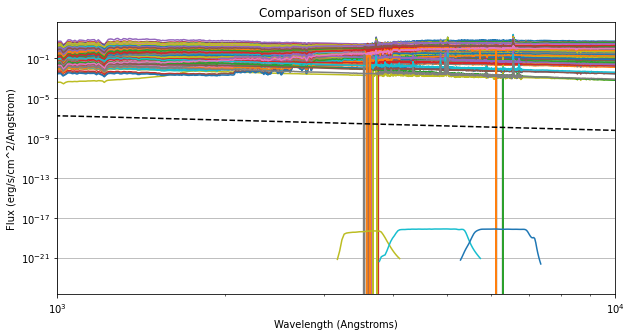

In [15]:
# We aim to explore how the ugr colour space may be influenced by contaminating the galaxy with an agn contribution
tau = SKIRTOR_PARAMS['tau'][2]
p = SKIRTOR_PARAMS['p'][1] # Can make this either 0.5 or 0 (we choose 0.5)
q = SKIRTOR_PARAMS['q'][0] # Make this zero, similar to the Ciesla paper
oa = SKIRTOR_PARAMS['oa'][4] # opening angle of 50 degrees
rr = SKIRTOR_PARAMS['rr'][1] # ratio of 20


i = SKIRTOR_PARAMS['i'][0] # inclination of 0 degrees

# Alternatively can choose a different model of 90
# i = SKIRTOR_PARAMS['i'][9] # inclination of 90 degrees

if i == 0:
    agn_model_type = 'Type 1'
if i == 90:
    agn_model_type = 'Type 2'

print(f'Using a {agn_model_type} AGN model')

# This is again, a new model
agn_model = read_skirtor_model(skirtor_folderpath, tau, p, q, oa, rr, i)

# Print the parameters used in the AGN model
print(f'Tau: {tau}, p: {p}, q: {q}, oa: {oa}, rr: {rr}, i: {i}')

# For completeness we will try to read in all of the galsedatlas templates 
# if this gives bad results we will selectively choose a large section of these templates
# read in all the template names
galsedatlas_templates, objname_list = read_brown_galaxy_templates(brown_folderpath)

# Make sure AGN are correctly scaled against the galaxy range   
# Have an original AGN model to adjust against 
type_1_agn = agn_model.copy()
type1agn_models = []


# When adjusting, we need to make sure we interpolate the data correctly at each point, 
# so for a specific AGN model this needs to be interpolated correctly against the relevant galaxy template
# essentially each AGN model will be specifically cut for it's template.
for i, template in enumerate(galsedatlas_templates):
    galsedatlas_templates[i], agn_model = adjust_wavelength_range(template, agn_model)   
    type1agn_models.append(agn_model)
    agn_model = type_1_agn.copy()


# Using the same alpha as before, we can create a composite of the AGN and the galaxy
# Use this as a comparison, but in actuality each AGN model will be adjusted to the specific galaxy template
wl_agn = type1agn_models[0]['lambda (Angstroms)']
fl_agn = type1agn_models[0]['Total Flux (erg/s/cm^2/Angstrom)']


plt.figure(figsize=(10, 5))
for i, template in enumerate(galsedatlas_templates):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label=objname_list[i])
plt.loglog(wl_agn, fl_agn, label='Type 1 AGN', color='black', linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()

#plt.legend()

# Plotting the scaled filters to show where the filters observe in

u_arr = np.array(pb_u.asList())
g_arr = np.array(pb_g.asList())
r_arr = np.array(pb_r.asList())
sc = 1e-18
plt.loglog(u_arr[:, 0], sc*u_arr[:,1])
plt.loglog(g_arr[:, 0], sc*g_arr[:,1])
plt.loglog(r_arr[:, 0], sc*r_arr[:,1])
plt.xlim(1e3, 1e4)
plt.show()


In [16]:
# Now we know this is effective, we do the same thing on the GALSEDATLAS full template set


# # So for every GALSEDATLAS template we will create a composite with the AGN model
# for i, template in enumerate(galsedatlas_templates):
#     print(f'Creating composite for {objname_list[i]}')
#     agn_model = type1agn_models[i]
#     type1composite_list = []
#     for a in alpha:
#         composite_galaxy = create_gal_agn_composite_sed(agn_model, template, a, 1)
#         type1composite_list.append(composite_galaxy)
#     type1composites.append(type1composite_list)
    


In [17]:
    
# thus we create composites for each galaxy template with the AGN model at different values of alpha.
# To improve this code instead of for each template creating 10 values, we can, for every value of alpha, create a compsoite for each template
# this will improve accessing and reading the composite data. Thus for each value of alpha, we will have a list of composites for all galsedatlas templates

# Create a list of alpha values
spacing = 11
alpha = np.linspace(0, 1, spacing)
type1composites = []

# Create new composites
composite_alpha = []


# This is a useful method, it creates a composite for each template in the template set
# for each value of alpha. So there are a set of composites for each value of alpha
# rather than the previous function which was a set of alpha values for each composite
# 10 lists with 127 composites in them
# rather than 127 lists with 10 composites in them 
for a in alpha:
    # for this value of alpha create a composite for each template
    composite_templates = []
    for i, template in enumerate(galsedatlas_templates):
        agn_model = type1agn_models[i]
        composite_galaxy = create_gal_agn_composite_sed(agn_model, template, a, 1)
        composite_templates.append(composite_galaxy)
    composite_alpha.append(composite_templates)
    
    
# Now we have a list of composites for each value of alpha, we can now calculate the ugr colours for each composite at each value of alpha
# We can then plot the ugr colours for each value of alpha, and see how the ugr colours change as the AGN contribution increases. As
# we are exploring a redshift non-restframe technique, we will need to explore all composites keeping the agn contribution fixed, 
# and explore how these compsoites change with redshifting
        





In [18]:
#composite_alpha[0][128]['Total Flux (erg/s/cm^2/Angstrom)']

In [19]:
# We know this works as per the previous notebooks, so we look at now exploring, for each value of alpha, a change in the redshift
# of the composite. We will explore how the ugr colours change as the redshift increases. We will explore this for a range of redshifts
# This will be a similar process to the work explored in Sam's thesis but will be done on composites created using Skirtor models
# As we allready have our list of created SEDs

# So to do this we create a new set of composites. For each value of the alpha lists we assume a redshift of 0
# we use the astLib library to redshift each of these seds to a new redshift. We then calculate the ugr colours for each of these redshifted

# We begin by only doing this for 3 alpha values, 0, 0.5 and 1. We will then explore how the ugr colours change as the redshift increases


list_of_alpha_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 


# Using a variation of Sam's code

ug_specific_alpha_colours = []
gr_specific_alpha_colours = []
redshifts_alpha_list = []



ug_colours = []
gr_colours = []
redshifts_list = []

for n in list_of_alpha_indices:
    
    
    # This will be the set of composites for the specific alpha value
    sed_alpha_data = composite_alpha[n] # 127 compsites at a specific alpha value
    for sed_data in sed_alpha_data:
        
        # Create an SED object using astSED
        wl = sed_data['lambda (Angstroms)']
        fl = sed_data['Total Flux (erg/s/cm^2/Angstrom)']
        sed = astSED.SED(wavelength=wl, flux=fl, z=0.0) # Create the specified SED object at redshift of 0
        
        # Now we need to redshift the SED templates to the appropriate redshifts, we are going from 0 to 4 in steps of 0.1
        for z in np.arange(0, 4, 0.1):
            # Redshift the SED template
            #sed = sed.redshift(z)
            sed.redshift(z)
            #astSED.SED.calcColour(pb_u, pb_g)
            # Calculate the UGR and UVJ colours
            ug = astSED.SED.calcColour(sed, pb_u, pb_g, magType='AB')
            gr = astSED.SED.calcColour(sed, pb_g, pb_r, magType='AB')
            
            # Append colours to list
            ug_colours.append(ug)
            gr_colours.append(gr)
            redshifts_list.append(z)
            
    
    
    
       
    ug_specific_alpha_colours.append(ug_colours)
    gr_specific_alpha_colours.append(gr_colours)
    redshifts_alpha_list.append(redshifts_list)
    
    ug_colours = []
    gr_colours = []        
    redshifts_list = []
            
            
            

        

 
# we need to make sure there are pd.Dataframes for each of the ugr colours at each value of alpha
# at each specific alpha value, we have a list of ugr colours, we need to convert the datafram inside the list into a pd.DataFrame
# for each value

ug_specific_alpha_colours = [pd.DataFrame(ug) for ug in ug_specific_alpha_colours]
gr_specific_alpha_colours = [pd.DataFrame(gr) for gr in gr_specific_alpha_colours]
redshifts_alpha_list = [pd.DataFrame(redshifts) for redshifts in redshifts_alpha_list]









In [20]:
# # for each of the alpha values we can generate a plot
# # We can use the selection technique plot outlined in sam's thesis to show how the ugr colours change with increasing redshift
# # similarly we can also explore how when we change the agn contribution this effects the ugr colours


# # first explore the UGR diagram
# alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# # Create subplot for each alpha value 
# # setup subplot grid

# for n in range(len(list_of_alpha_indices)):
    
    
    

#     # Plot the UGR diagram for the SED templates at different redshifts
#     plt.scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] > 3.5)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] > 3.5)], c="#FFC0CB", s=10, label="z > 3.5")
#     plt.scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] > 2.6)& (redshifts_alpha_list[n] <= 3.5)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] > 2.6)& (redshifts_alpha_list[n] <= 3.5)], c="#ADD8E6", s=10, label="2.6 < z < 3.5")
#     plt.scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] < 2.6)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] < 2.6)], c="#90EE90", s=10, label="z < 2.6")
#     plt.xlabel("G-R")
#     plt.ylabel("U-G")
#     plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alphas[n]))

#     # Additionally we can plot the UGR selection criteria on the UGR diagram
#     U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
#     plt.gca().add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

#     plt.xlim(-1, 4)
#     plt.ylim(-1, 8.5)

    
    
    
#     # In addition we can plot a mean position for on each of the alpha plots. This mean value will be the mean of the ugr
#     # colours in a particular redshift range. I.e 3 redshift ranges, 0 < z < 2.6, 2.6 < z < 3.5, z > 3.5
    
#     # We can calculate the mean ugr colours for each of these redshift ranges
#     mean_ugr = []
#     mean_ugr.append([ug_specific_alpha_colours[n][(redshifts_alpha_list[n] < 2.6)].mean(), gr_specific_alpha_colours[n][(redshifts_alpha_list[n] < 2.6)].mean()])
#     mean_ugr.append([ug_specific_alpha_colours[n][(redshifts_alpha_list[n] > 2.6) & (redshifts_alpha_list[n] <= 3.5)].mean(), gr_specific_alpha_colours[n][(redshifts_alpha_list[n] > 2.6) & (redshifts_alpha_list[n] <= 3.5)].mean()])
#     mean_ugr.append([ug_specific_alpha_colours[n][(redshifts_alpha_list[n] > 3.5)].mean(), gr_specific_alpha_colours[n][(redshifts_alpha_list[n] > 3.5)].mean()])
    
#     # Plot the mean ugr colours on the UGR diagram
#     plt.scatter([mean_ugr[0][1]], [mean_ugr[0][0]], c="green", s=50, label="Mean z < 2.6")
#     plt.scatter([mean_ugr[1][1]], [mean_ugr[1][0]], c="blue", s=50, label="Mean 2.6 < z < 3.5")
#     plt.scatter([mean_ugr[2][1]], [mean_ugr[2][0]], c="red", s=50, label="Mean z > 3.5")
    
#     plt.legend()
    
    
    
#     # Save each plot
#     #plt.savefig(f'outputs/UGRPlots/ugr_alpha_{alphas[n]}_{agn_model_type}.png')

#     plt.show()


# # plt.figure(figsize=(10, 10))

# # # Plot the UGR diagram for the SED templates at different redshifts
# # plt.scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] > 3.5)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] > 3.5)], c="red", s=10, label="z > 3.5")
# # plt.scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] > 2.6)& (redshifts_alpha_list[n] <= 3.5)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] > 2.6)& (redshifts_alpha_list[n] <= 3.5)], c="blue", s=10, label="2.6 < z < 3.5")
# # plt.scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] < 2.6)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] < 2.6)], c="green", s=10, label="z < 2.6")
# # plt.xlabel("G-R")
# # plt.ylabel("U-G")
# # plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4)")

# # # Additionally we can plot the UGR selection criteria on the UGR diagram
# # U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
# # plt.gca().add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

# # plt.xlim(-1, 4)
# # plt.ylim(-1, 8.5)

# # plt.legend()


# # plt.show()

# # Editing the above to work with differrent alpha values

# # For each alpha value we can plot the UGR diagram
# # We are plotting for 3 alpha values, 0, 0.5 and 1





0
1
2
3
4
5
6
7
8
9
10


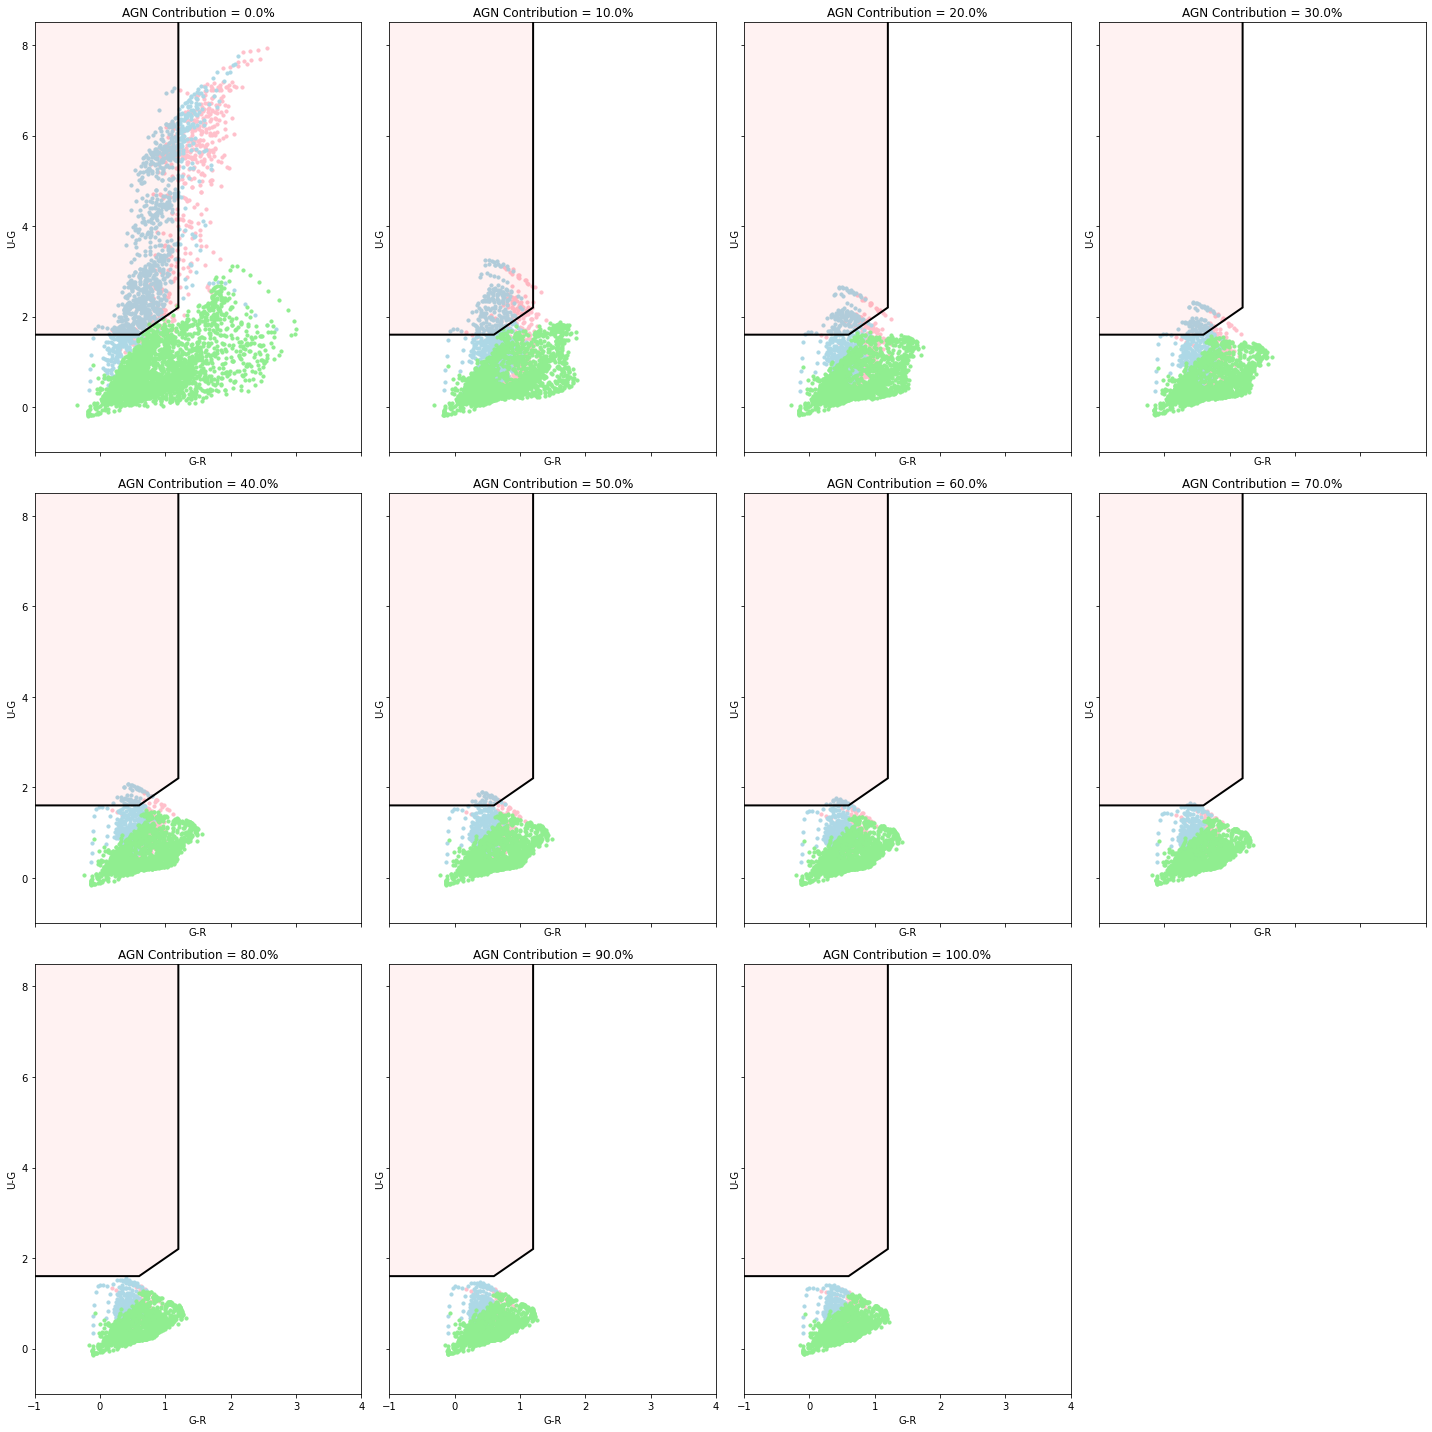

In [21]:
# Instead of many individual plots, instead we wish to subplot all of the plots for each alpha value
# We can do this by creating a subplot for each alpha value, and then plotting the UGR diagram for each redshift range
# on each subplot. We can then save this plot

# # Setup subplot
# fig, axs = plt.subplots(11, 1, figsize=(10, 20))

# for n in range(len(list_of_alpha_indices)):
#     print(n)
#     # Plot the UGR diagram for the SED templates at different redshifts
#     axs[n].scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] > 3.5)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] > 3.5)], c="#FFC0CB", s=10, label="z > 3.5")
#     axs[n].scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] > 2.6)& (redshifts_alpha_list[n] <= 3.5)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] > 2.6)& (redshifts_alpha_list[n] <= 3.5)], c="#ADD8E6", s=10, label="2.6 < z < 3.5")
#     axs[n].scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] < 2.6)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] < 2.6)], c="#90EE90", s=10, label="z < 2.6")
#     axs[n].set_xlabel("G-R")
#     axs[n].set_ylabel("U-G")
#     axs[n].set_title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alpha[n]))

#     # Additionally we can plot the UGR selection criteria on the UGR diagram
#     U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
#     axs[n].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

#     axs[n].set_xlim(-1, 4)
#     axs[n].set_ylim(-1, 8.5)

#     # In addition we can plot a mean position for on each of the alpha plots. This mean value will be the mean of the ugr
#     # colours in a particular redshift range. I.e 3 redshift ranges, 0 < z < 2
#     # We can calculate the mean ugr colours for each of these redshift ranges
    
#     # Show the plot
# plt.show()


# Do the same thing but do it in 3x4 grid of subplots
# Setup subplot
fig, axs = plt.subplots(3, 4, figsize=(20, 20), sharex=True, sharey=True)




for n in range(len(list_of_alpha_indices)):
    print(n)
    # Plot the UGR diagram for the SED templates at different redshifts
    axs[n//4, n%4].scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] > 3.5)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] > 3.5)], c="#FFC0CB", s=10, label="z > 3.5")
    axs[n//4, n%4].scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] > 2.6)& (redshifts_alpha_list[n] <= 3.5)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] > 2.6)& (redshifts_alpha_list[n] <= 3.5)], c="#ADD8E6", s=10, label="2.6 < z < 3.5")
    axs[n//4, n%4].scatter(gr_specific_alpha_colours[n][(redshifts_alpha_list[n] < 2.6)], ug_specific_alpha_colours[n][(redshifts_alpha_list[n] < 2.6)], c="#90EE90", s=10, label="z < 2.6")
    axs[n//4, n%4].set_xlabel("G-R")
    axs[n//4, n%4].set_ylabel("U-G")
    axs[n//4, n%4].set_title(f"AGN Contribution = {round(alpha[n], 1)*100}%")
    
    # add the alpha value information onto the plot somewhere
    #axs[n//4, n%4].text(0.5, 0.9, f"alpha = {round(alpha[n], 2)}", horizontalalignment='center', verticalalignment='center', transform=axs[n//4, n%4].transAxes)

    # Additionally we can plot the UGR selection criteria on the UGR diagram
    U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
    axs[n//4, n%4].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

    axs[n//4, n%4].set_xlim(-1, 4)
    axs[n//4, n%4].set_ylim(-1, 8.5)
    
    # In addition we can plot a mean position for on each of the alpha plots. This mean value will be the mean of the ugr
# Remove final plot
fig.delaxes(axs[2, 3])

# # Make all the plots touch
# plt.subplots_adjust(wspace=-0.5, hspace=0)

plt.tight_layout()    

# Save the output
plt.savefig(f'outputs/UGRPlots/ugr_alpha_{agn_model_type}.png')


# Plot
plt.show()
    

In [22]:
# Make them all touching
